# NB3 Basin anaysis <a id='top'></a>

Purpose: 

**Look into flow series and river properties for a particular basin**

1. plot monthly flow for a specified basin along with river network map
2. plot a river network with various river properties
3. Interactive map with topography background

Use: 

1. reach-D19 gauge link ascii
2. River flowline geopackage
3. River catchment geopackage (could take long to load)
4. River network netCDF (used for mizuRoute input)
5. D19 flow site geopackage
6. D19 discharge netCDF
7. monthly and yearly flow netCD (history file)

[1. Some analysis setupt](#setup2)

[2. Loading data](#load_flow_data2)

- monthly history files (directory from CESM or postprocessed) from archive. 

- Reference data is monthly discharge estimates at 922 big river mouths from Dai et al. 2019 data (D19)

[3. load_gauge_data](#load_gauge_data2)

[4. Mapping and plotting flow time series for a basin](#plot3)

[5. Mapping river properties for a basin](#plot4)

[6. Interactive mapping](#plot5)

In [5]:
%matplotlib inline

import os, sys
import time
import tomli
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
import folium
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

from scripts.utility import load_toml
from scripts.utility import read_shps

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)
print(pd.__name__, pd.__version__)
print(gpd.__name__, gpd.__version__)


The Python version: 3.10.12
xarray 2023.6.0
pandas 2.0.3
geopandas 0.13.2


In [6]:
rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')
land = cfeature.LAND
stamen_terrain = cimgt.Stamen('terrain-background')

-------------------------
## Functions

- subset_basin: subset basin with outlet site ID and return dataframe


In [7]:
def subset_basin(elem, nextElem, outlet_id):
    
    # search upstream elements
    id_int = int(outlet_id)
    all_ups_ids = [id_int]
    immediate_ups_ids = np.unique(elem[np.where(nextElem==id_int)])
    all_ups_ids.extend(list(immediate_ups_ids))
    round_num = 0
    
    while len(immediate_ups_ids) != 0:

        round_num = round_num+1

        # search upstream elem
        immediate_ups_ids_next = []
        for huc_i in immediate_ups_ids:
            immediate_ups_ids_next.extend(list(elem[np.where(nextElem==huc_i)]))
        immediate_ups_ids_next = np.unique(immediate_ups_ids_next)

        # identify if found HUC exists in upstrm_elem
        immediate_ups_ids = [huc for huc in immediate_ups_ids_next if not huc in all_ups_ids]
        all_ups_ids.extend(immediate_ups_ids)
    
    return all_ups_ids

-------------------------
## 1. Analysis setup <a id='setup2'></a>

**Please provide CESM case names and ROF grid name, and gauge ID**

[Move to 3.5 Subset river network shapefile](#subset_river_data)


[go back to top](#top)

In [19]:
gauge_id = 9400   # Fraser=9504  Magdalena=9400  Indus=9275  Nelson=9483  Sepik=9736  Atrato=9403, Mackanzie=10224, amazon=81168 Rhone=9802

cases = {
        'f09_f09_rHDMA':'rHDMA',
        'f09_f09_rHDMAlk_mg17':'rHDMAlk',
        'f09_f09_mg17_mosart':'f09_f09_mosart',
        }

readBasinGPKG = False

-------------------------
load config files and some parameters 

In [20]:
setup = load_toml('./setup/setup.toml')

main_dir       = setup['archive_dir']
domain_dir     = setup['ancillary_dir']
geospatial_dir = setup['geospatial_dir']
ancillary_dir  = setup['ancillary_dir']
ref_flow_dir   = setup['ref_flow_dir']

eyr = setup['eyr']
syr = setup['syr']

rof_grid = setup['rof_grid']

reach_gpkg = setup['reach_gpkg']
catch_gpkg = setup['catch_gpkg']

network = setup['river_network']

time_period = slice(f'{syr}-01-01',f'{eyr}-12-31') # analysis time period
nyrs = eyr-syr+1  # number of years
nmons = nyrs*12   # number of months

---
## 2. Loading flow data <a id='load_flow_data2'></a>

[go back to top](#top)

### 2.1.  Read monthly/annual flow netCDFs

In [6]:
%%time
reachID_list = {}
month_data = {}
year_data  = {}
seas_data  = {}
for case, grid_name in cases.items():
    in_dire = os.path.join(main_dir, case, 'rof/hist')
    model  = rof_grid[grid_name]['model']
    domain = rof_grid[grid_name]['domain_nc']
    #monthly
    month_data[case] = xr.open_mfdataset(f'{in_dire}/{case}.{model}.*.month.nc', data_vars='minimal').sel(time=time_period).load()
    #annual
    year_data[case] = xr.open_mfdataset(f'{in_dire}/{case}.{model}.*.annual.nc', data_vars='minimal').sel(time=time_period).load()
    #seasonal
    seas_data[case] = xr.open_mfdataset(f'{in_dire}/{case}.{model}.*.seasonal.nc', data_vars='minimal').load()
    
    if domain=='None':  #wish domain = None (not string)
        reachID_list[case] = month_data[case]['reachID'].values 
    else:
        reachID_list[case] = xr.open_dataset(f'{domain_dir}/{domain}')['reachID'].values


CPU times: user 8.16 s, sys: 22.5 s, total: 30.7 s
Wall time: 1min 31s


### 2.2. D19 discharge data

In [21]:
%%time
# read monthly data
ds_q = xr.open_dataset('%s/D09/coastal-stns-Vol-monthly.updated-May2019.mod.nc'%(ref_flow_dir),decode_times=False)
ds_q['time']= xr.cftime_range(start='1900-01-01', end='2018-12-01', freq="MS", calendar="standard")

# monthly
ds_q_obs_mon = ds_q['FLOW'].sel(time=time_period)
# compute annual flow from monthly
ds_q_obs_yr = ds_q_obs_mon.resample(time="1A").mean(dim="time")
# compute annual cycle at monthly scale
dr_q_obs_seasonal = ds_q_obs_mon.sel(time=time_period).groupby('time.month').mean('time')

CPU times: user 33.8 ms, sys: 3 ms, total: 36.8 ms
Wall time: 60.9 ms


-------------------------
## 3. Loading gauge data (shapefile and gauge-reach link file) <a id='load_gauge_data2'></a>

### 3.1. Read reach-D19 gauge link csv

In [22]:
gauge_reach_lnk = {}
for case, grid_name in cases.items():
    gauge_reach_lnk[case] = pd.read_csv('%s/D09/D09_925.%s.asc'%(ref_flow_dir, rof_grid[grid_name]['network']))

### 3.2. Read D19 flow site shapefile

In [24]:
gauge_shp = gpd.read_file(os.path.join(ref_flow_dir, 'D09', 'geospatial','D09_925.gpkg'))
gauge_shp = gauge_shp[gauge_shp['id']!=9999999]

### 3.3. Read global river reach geopackage
- global_river (dataframe)

In [10]:
%%time
## river
global_river = {}
for case, grid_name in cases.items():
    
    network_name = rof_grid[grid_name]['network']
    
    riv_gpkg = os.path.join(geospatial_dir, reach_gpkg[network_name]['file_name'])  # geopackage name
    id_name_river = reach_gpkg[network_name]['id_name']                               # reach ID in geopackage
    downid_name = reach_gpkg[network_name]['down_id_name']                          # downstream reach ID in geopackage
    global_river[network_name] = read_shps([riv_gpkg], [id_name_river, downid_name])

Finished reading /glade/campaign/ral/hap/mizukami/proj/ctsm-mizuRoute/geospatial/hdma_global_stream.shp
Finished reading /glade/campaign/ral/hap/mizukami/proj/ctsm-mizuRoute/geospatial/hdma_global_stream.shp
Finished reading /glade/campaign/ral/hap/mizukami/proj/ctsm-mizuRoute/geospatial/MOSART_stream0.5.shp
CPU times: user 1min 38s, sys: 2.75 s, total: 1min 41s
Wall time: 1min 44s


In [16]:
%%time
## catchment
global_catch = {}
for case, grid_name in cases.items():
    
    network_name = rof_grid[grid_name]['network']
    
    cat_gpkg = os.path.join(geospatial_dir, catch_gpkg[network_name]['file_name'])  # geopackage name
    id_name_cat = catch_gpkg[network_name]['id_name']                              # reach ID in geopackage
    var_list = [id_name_cat]
    if 'lk' in case:
        var_list.append('lake')
    global_catch[network_name] = read_shps([cat_gpkg], var_list)

Finished reading /glade/campaign/ral/hap/mizukami/proj/ctsm-mizuRoute/geospatial/hdma_global_catch_v2_0.01.gpkg
Finished reading /glade/campaign/ral/hap/mizukami/proj/ctsm-mizuRoute/geospatial/hdma_hydrolake_global_catch_v1_0.01.gpkg
Finished reading /glade/campaign/ral/hap/mizukami/proj/ctsm-mizuRoute/geospatial/mosart0.5_global_land.gpkg
CPU times: user 1min 57s, sys: 1.96 s, total: 1min 59s
Wall time: 2min 5s


### 3.4. Read river network
- global_river (ds)

In [30]:
reach_properties =['Length','Slope','man_n','totalArea','streamOrder','seg_id','Tosegment', 'width', 'depth']
riv_network = {}
for case, grid_name in cases.items():
    
    network_name = rof_grid[grid_name]['network']
    network_file = os.path.join(ancillary_dir, network[network_name]['file_name'])  # geopackage name
    print(f"reading {network_file}...")
    ds_rn = xr.open_dataset(network_file)[reach_properties].set_index(seg='seg_id')
    riv_network[case] = ds_rn.to_dataframe()

reading /glade/u/home/mizukami/proj/ctsm-mizuRoute/scripts/ancillary_data/ntopo_HDMA.v2.aug.nc...
reading /glade/u/home/mizukami/proj/ctsm-mizuRoute/scripts/ancillary_data/Network_topology_HDMA_HydroLake_v3_aug.nc...
reading /glade/u/home/mizukami/proj/ctsm-mizuRoute/scripts/ancillary_data/mizuRoute_MOSART_Global_half_20161105a_aug.nc...


### 3.5. Subset river network shapefile <a id='subset_river_data'></a>

In [112]:
river_name = gauge_shp[gauge_shp['id']==gauge_id]['riv_name'].values[0]
print(river_name)

seg_id={}
seg_ix={}
basin_area={}
for case, _ in cases.items():
    seg_id[case] = gauge_reach_lnk[case][gauge_reach_lnk[case]['gauge_id']==gauge_id]['route_id'].values
    basin_area[case] = {'ref':gauge_reach_lnk[case][gauge_reach_lnk[case]['gauge_id']==gauge_id]['gauge_area'].values,
                        'model':gauge_reach_lnk[case][gauge_reach_lnk[case]['gauge_id']==gauge_id]['route_area'].values}
    seg_ix[case] = np.argwhere(reachID_list[case]==seg_id[case])   # matching reach ix in river network
    if len(seg_ix[case])==0:
        seg_ix[case] = -999
    else:
        seg_ix[case] = seg_ix[case][0]
        
gauge_ix = np.argwhere(ds_q.id.values==gauge_id)[0]

Magdalena


In [113]:
reach_shp = {}
for case, grid_name in cases.items():
    start_time = time.time()
    network_name = rof_grid[grid_name]['network']
    
    basin_river_gpkg = os.path.join(geospatial_dir, 'basins', f"{grid_name}_{river_name}_line.gpkg")
    if readBasinGPKG & os.path.isfile(basin_river_gpkg):
        reach_shp[case] = gpd.read_file(basin_river_gpkg)
    else:
        upstream_id = subset_basin(riv_network[case].index, riv_network[case]['Tosegment'], seg_id[case])
        id_name     = reach_gpkg[network_name]['id_name'] # id name in geopackage
        reach_sub = global_river[network_name][global_river[network_name][id_name].isin(upstream_id)]
        reach_shp[case] = pd.merge(reach_sub, riv_network[case], left_on='seg_id', right_index=True)
        reach_shp[case].to_file(basin_river_gpkg, layer='line', driver="GPKG")
    print('Finished subsetting network-%s: %.4f [sec]'%(network_name, time.time()-start_time))

Finished subsetting network-HDMA: 0.6089 [sec]
Finished subsetting network-HDMA_lake: 0.5681 [sec]
Finished subsetting network-mosart: 0.1953 [sec]


In [114]:
catch_shp = {}
lake_shp = {}
for case, grid_name in cases.items():
    start_time = time.time()
    network_name = rof_grid[grid_name]['network']
    
    basin_catch_gpkg = os.path.join(geospatial_dir, 'basins', f"{grid_name}_{river_name}_catch.gpkg")
    if readBasinGPKG & os.path.isfile(basin_catch_gpkg):
        catch_shp[case] = gpd.read_file(basin_catch_gpkg)
    else:
        upstream_id = subset_basin(riv_network[case].index, riv_network[case]['Tosegment'], seg_id[case])
        id_name_cat = catch_gpkg[network_name]['id_name']
        catch_shp[case] = global_catch[network_name][global_catch[network_name][id_name_cat].astype('int').isin(upstream_id)]
        catch_shp[case].to_file(basin_catch_gpkg, layer='catchment', driver="GPKG")
    print('Finished subsetting catchment-%s: %.4f [sec]'%(network_name, time.time()-start_time))

Finished subsetting catchment-HDMA: 0.3302 [sec]
Finished subsetting catchment-HDMA_lake: 0.3999 [sec]
Finished subsetting catchment-mosart: 0.0792 [sec]


## 4. Mapping and plotting flow time series  <a id='plot3'></a>

[go back to top](#top)

In [36]:
cases

{'f09_f09_rHDMA': 'rHDMA',
 'f09_f09_rHDMAlk_mg17': 'rHDMAlk',
 'f09_f09_mg17_mosart': 'mosart'}

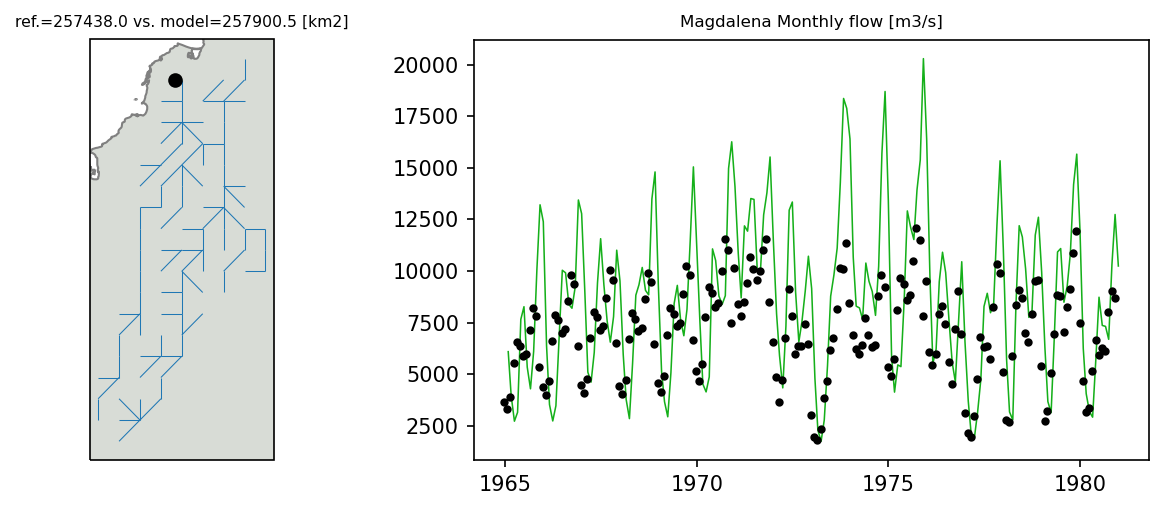

In [117]:
case_plot='f09_f09_mg17_mosart'

fig = plt.figure(figsize=(9.0,3.5), dpi=150)

ax1 = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(1,2,2)

# plot a network map in left axis
minx, miny, maxx, maxy = reach_shp[case_plot].geometry.total_bounds
#ax1.add_feature(rivers_50m, facecolor='None', edgecolor='b', lw=0.5, alpha=0.3)
#ax1.stock_img()
#ax1.set_extent([minx-0.1, maxx+1.1, miny-0.1, maxy+0.1], crs=ccrs.PlateCarree())
ax1.add_feature(land, facecolor='xkcd:light grey', edgecolor='grey')

reach_shp[case_plot].plot(ax=ax1, lw=0.5, zorder=0);
if 'lk' in case_plot:
    catch_shp[case_plot].loc[catch_shp[case_plot]['lake'] == 1].plot(ax=ax1, color='c', zorder=1)
    
gauge_shp[gauge_shp['id']==gauge_id].plot(ax=ax1, c='k');
ax1.set_title('ref.=%.1f vs. model=%.1f [km2]'%(basin_area[case_plot]['ref'], basin_area[case_plot]['model'],), fontsize=7.5)

# plot a monthly flow in right axis
grid_name=cases[case_plot]
q_name = rof_grid[grid_name]['flow_name']
color = rof_grid[grid_name]['color']
if len(seg_ix[case_plot])==1:
    month_data[case_plot][q_name][:,seg_ix[case_plot][0]].plot(ax=ax2, linestyle='-', c=color, lw=0.75, label=case);
elif len(seg_ix[case_plot])==2:   # means 2d grid
    month_data[case_plot][q_name][:,seg_ix[case_plot][0],seg_ix[case_plot][1]].plot(ax=ax2, linestyle='-', c=color, lw=0.75, label=case)
ds_q_obs_mon[:,gauge_ix].plot(ax=ax2, linestyle='None',marker='o',markersize=3, c='k',label='D17');
ax2.set_title('%s Monthly flow [m3/s]'%(river_name), fontsize=8)
ax2.set_xlabel('');
ax2.set_ylabel('');

plt.tight_layout()
plt.savefig(f"./Figures/NB3_{river_name}_{case_plot}_map_flow.png", dpi=150)

## 5. mapping river network properties  <a id='plot4'></a>

[go back to top](#top)

In [61]:
cases

{'f09_f09_rHDMA': 'rHDMA',
 'f09_f09_rHDMAlk_mg17': 'rHDMAlk',
 'f09_f09_mg17_mosart': 'mosart'}

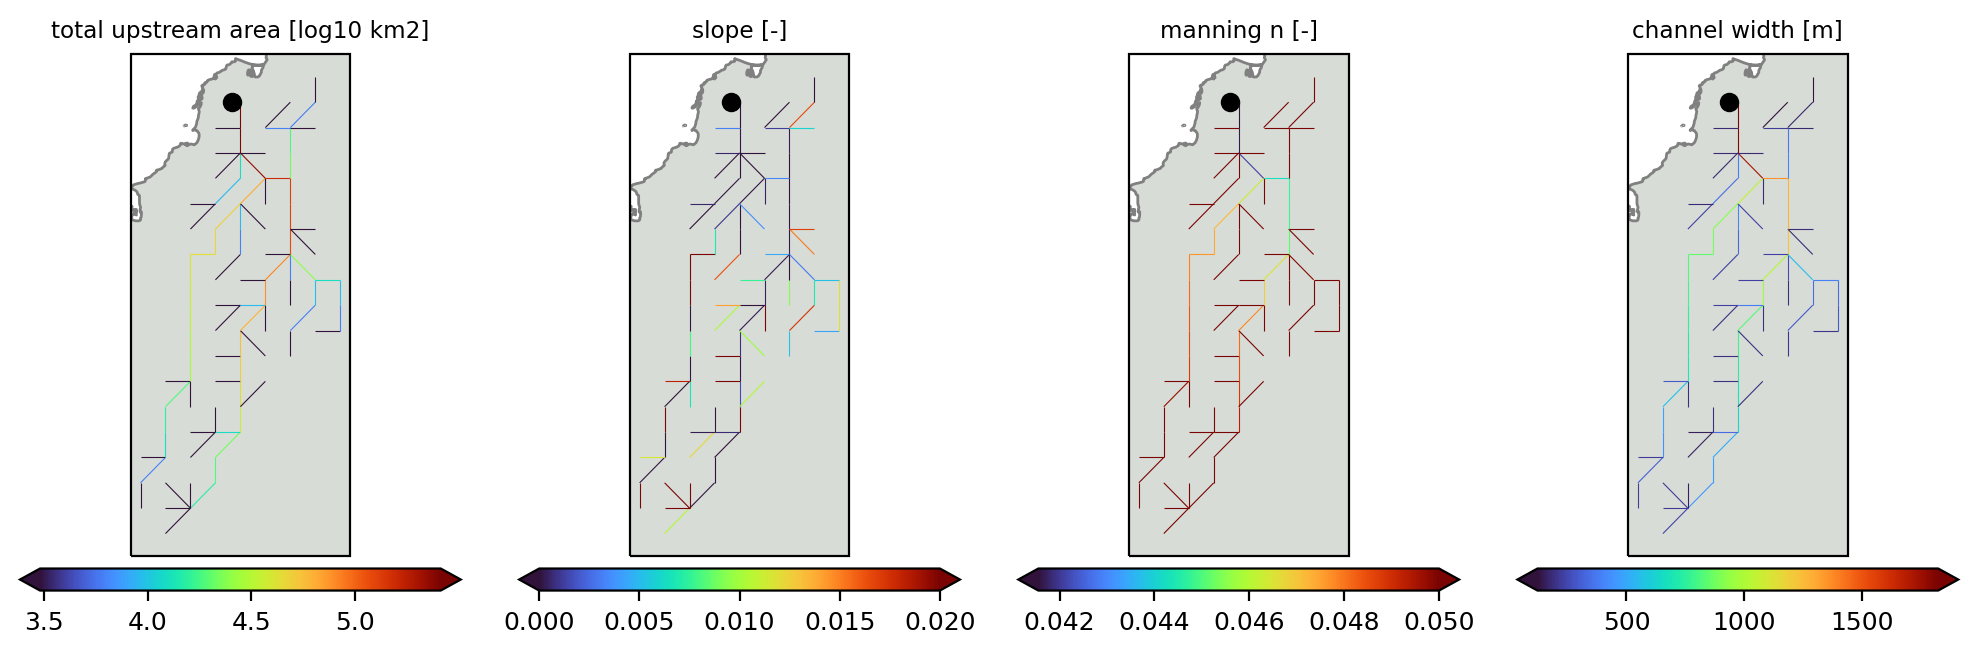

In [120]:
case_plot='f09_f09_mg17_mosart'

cbar_kwrgs = {"shrink":1.0, "pad":0.02, "orientation": "horizontal", 'extend':'both'}

reach_shp[case_plot]['log_totalArea'] = np.log10(reach_shp[case_plot]['totalArea']/1000000)  # log sq-km

reachvars = {
             'log_totalArea':{'unit':'total upstream area [log10 km2]'},
             'Slope':        {'unit':'slope [-]'},
             'man_n':        {'unit':'manning n [-]'},
             'width':        {'unit':'channel width [m]'},
             }

fig = plt.figure(figsize=(10.0,3.5), dpi=200)

ax = []
for ix in np.arange(len(reachvars)):
    ax.append(fig.add_subplot(1,4,ix+1, projection=ccrs.PlateCarree()))

# plot a network map in left axis
for ix in np.arange(len(reachvars)):
    ax[ix].add_feature(land, facecolor='xkcd:light grey', edgecolor='grey')

for ix, (var, meta) in enumerate(reachvars.items()):
    vmin = reach_shp[case_plot][var].min()
    vmax = reach_shp[case_plot][var].max()
    if var=='Slope':
        vmin = 0; vmax=0.02
    reach_shp[case_plot].plot(ax=ax[ix], column=var, cmap='turbo', lw=0.4, vmin=vmin, vmax=vmax,
                              zorder=0, legend=False);
    if 'lk' in case_plot:
        catch_shp[case_plot].loc[catch_shp[case_plot]['lake'] == 1].plot(ax=ax[ix], color='c', zorder=1)
    gauge_shp[gauge_shp['id']==gauge_id].plot(ax=ax[ix], c='k');

    ax[ix].set_title(meta['unit'], fontsize='small')
    points = ax[ix].collections[0]
    cbar = plt.colorbar(points, ax=ax[ix], **cbar_kwrgs);
    cbar.ax.tick_params(labelsize=9)

plt.tight_layout()
plt.savefig(f"./Figures/NB3_{river_name}_{case_plot}_map.png", dpi=150)

-------

## 6. Interactive river network map  <a id='plot5'></a>

[go back to top](#top)

In [110]:
# Experimental
case_plot='f09_f09_rHDMAlk_mg17'
reach_shp[case_plot].crs = "EPSG:4326"
bound = reach_shp[case_plot].total_bounds

riv_mouth_loc = [gauge_shp[gauge_shp['id']==gauge_id]['lat'].values, gauge_shp[gauge_shp['id']==gauge_id]['lon'].values]

map = folium.Map(location=[np.mean([bound[1],bound[3]]), np.mean([bound[0],bound[2]])],  # center of map
                 tiles='https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png', attr='My Data Attribution', 
                 zoom_start=8)

# plot chorpleth over the base map
folium.GeoJson(reach_shp[case_plot],
               style_function=lambda feature: {
                              "fillColor": "blue",
                              "fillOpacity": 1.0,
                              "color": "blue",
                              "weight": 2,
                               }
              ).add_to(map)


marker = folium.Marker(
    location=riv_mouth_loc,
#    popup=folium.Popup(max_width=450).add_child(
#        folium.Vega(data, width=450, height=250)
#    ),
)

marker.add_to(map)

map

## Animation

In [ ]:
import matplotlib as mpl
# create a colormap that consists of
# - 1/5 : custom colormap, ranging from white to the first color of the colormap
# - 4/5 : existing colormap

# set upper part: 4 * 256/4 entries
upper = mpl.cm.turbo(np.arange(256))

# set lower part: 1 * 256/4 entries
# - initialize all entries to 1 to make sure that the alpha channel (4th column) is 1
lower = np.ones((int(256/4),4))
# - modify the first three columns (RGB):
#   range linearly between grey (0.5,0.5,0.5) and the first color of the upper colormap
for i in range(3):
  lower[:,i] = np.linspace(0.75, upper[0,i], lower.shape[0])

# combine parts of colormap
cmap2 = np.vstack(( lower, upper ))

# convert to matplotlib colormap
cmap2 = mpl.colors.ListedColormap(cmap2, name='myColorMap', N=cmap2.shape[0])

In [ ]:
anim_period = slice('1970-01-01','2075-12-31')

case='f09_f09_rHDMAlk_mg17'
basin='Mackenzie'
ro_var_name = 'IRFroutedRunoff'

In [ ]:
ds_plot = month_data[case][['reachID','IRFvolume','IRFroutedRunoff']].sel(time=anim_period)

In [ ]:
import matplotlib.animation as animation

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

fig, ax = plt.subplots(1, figsize=(9.5, 5.5))
plt.subplots_adjust(left=0.05, bottom=0.025, right=0.985, top=0.95)

def init():
    sm = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=100, vmax=3000))
    cbar = fig.colorbar(sm, orientation='horizontal', shrink=0.65, pad=0.125)

def animate(t):
    plt.cla()
    ds_q1 = ds_plot.set_index(seg='reachID').isel(time=t, drop=True)
    datetime = ds_plot.time.isel(time=t).dt.strftime('%Y-%m-%d').values
    df_tmp = ds_q1[ro_var_name].to_dataframe()
    df_tmp['seg_id'] = df_tmp.index
    df_riv_q = pd.merge(reach_shp[case], df_tmp, on='seg_id')
    df_riv_q.plot(ax=ax,column=ro_var_name, lw=0.7, cmap=cmap2, vmin=100, vmax=3000)
    ax.set_title(f'{datetime} flow [m3/s]');
    ax.set_xlim([bound[1],bound[3]])
    ax.set_ylim([bound[0],bound[2]])
    
anim = animation.FuncAnimation(fig, animate, frames=91, init_func=init)

writergif = animation.PillowWriter(fps=3)
anim.save('flow_animiation.gif', writer=writergif)